In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [3]:
# Generate realistic synthetic training data
np.random.seed(42)

n_samples = 2000

# Model types with different power characteristics
model_types = ['ResNet50', 'BERT-Base', 'GPT-2', 'ViT', 'YOLO', 'CNN-Small']
model_power_map = {
    'ResNet50': 180, 'BERT-Base': 250, 'GPT-2': 350, 
    'ViT': 220, 'YOLO': 150, 'CNN-Small': 80
}

# Region carbon intensities (kg CO2 per kWh)
regions = ['us-east-1', 'us-west-2', 'eu-west-1', 'ap-south-1', 'ap-northeast-1']
region_carbon_map = {
    'us-east-1': 0.45,   # Virginia (coal-heavy)
    'us-west-2': 0.25,   # Oregon (hydro-heavy)
    'eu-west-1': 0.30,   # Ireland (wind-heavy)
    'ap-south-1': 0.70,  # Mumbai (coal-heavy)
    'ap-northeast-1': 0.50  # Tokyo (mixed)
}

data = []

for _ in range(n_samples):
    model_type = np.random.choice(model_types)
    region = np.random.choice(regions)
    
    # Features
    batch_size = np.random.choice([8, 16, 32, 64, 128])
    dataset_size_gb = np.random.randint(5, 500)
    gpu_count = np.random.choice([1, 2, 4, 8])
    gpu_type = np.random.choice(['T4', 'V100', 'A100'])
    duration_hours = np.random.uniform(0.5, 24)
    
    # GPU power consumption (watts)
    gpu_power_map = {'T4': 70, 'V100': 300, 'A100': 400}
    
    # Calculate power consumption
    base_power = 50  # CPU + system
    model_power = model_power_map[model_type]
    gpu_power = gpu_power_map[gpu_type] * gpu_count
    total_power_watts = base_power + model_power + gpu_power
    
    # Add variability based on batch size and dataset
    power_multiplier = 1 + (batch_size / 128 * 0.2) + (dataset_size_gb / 500 * 0.15)
    total_power_watts *= power_multiplier
    
    # Calculate energy consumption
    energy_kwh = (total_power_watts / 1000) * duration_hours
    
    # Calculate carbon emissions
    carbon_intensity = region_carbon_map[region]
    carbon_kg = energy_kwh * carbon_intensity
    
    # Add some noise
    carbon_kg *= np.random.uniform(0.95, 1.05)
    
    data.append({
        'model_type': model_type,
        'batch_size': batch_size,
        'dataset_size_gb': dataset_size_gb,
        'gpu_count': gpu_count,
        'gpu_type': gpu_type,
        'duration_hours': duration_hours,
        'region': region,
        'carbon_kg': carbon_kg
    })

df = pd.DataFrame(data)

print(f"📊 Generated {len(df)} training samples")
print(f"\n📈 Carbon Statistics:")
print(f"   Mean: {df['carbon_kg'].mean():.2f} kg CO2")
print(f"   Median: {df['carbon_kg'].median():.2f} kg CO2")
print(f"   Min: {df['carbon_kg'].min():.2f} kg CO2")
print(f"   Max: {df['carbon_kg'].max():.2f} kg CO2")

df.head(10)

📊 Generated 2000 training samples

📈 Carbon Statistics:
   Mean: 7.50 kg CO2
   Median: 4.38 kg CO2
   Min: 0.07 kg CO2
   Max: 64.97 kg CO2


,model_type,batch_size,dataset_size_gb,gpu_count,gpu_type,duration_hours,region,carbon_kg
0,ViT,32,76,1,T4,4.166438,ap-northeast-1,0.733719
1,GPT-2,128,104,8,A100,0.983736,eu-west-1,1.369537
2,ViT,64,281,1,V100,12.831776,us-west-2,2.150788
3,ResNet50,32,174,8,A100,11.217645,eu-west-1,13.085466
4,GPT-2,64,324,1,A100,20.708600,ap-south-1,14.134042
5,ResNet50,64,93,8,V100,19.497338,us-west-2,14.176602
6,YOLO,64,96,4,A100,14.834921,us-west-2,7.786627
7,GPT-2,64,54,8,V100,10.491163,us-east-1,14.323969
8,ViT,16,222,8,V100,9.786031,ap-northeast-1,14.869505
9,CNN-Small,8,194,8,T4,9.633916,ap-south-1,4.868244


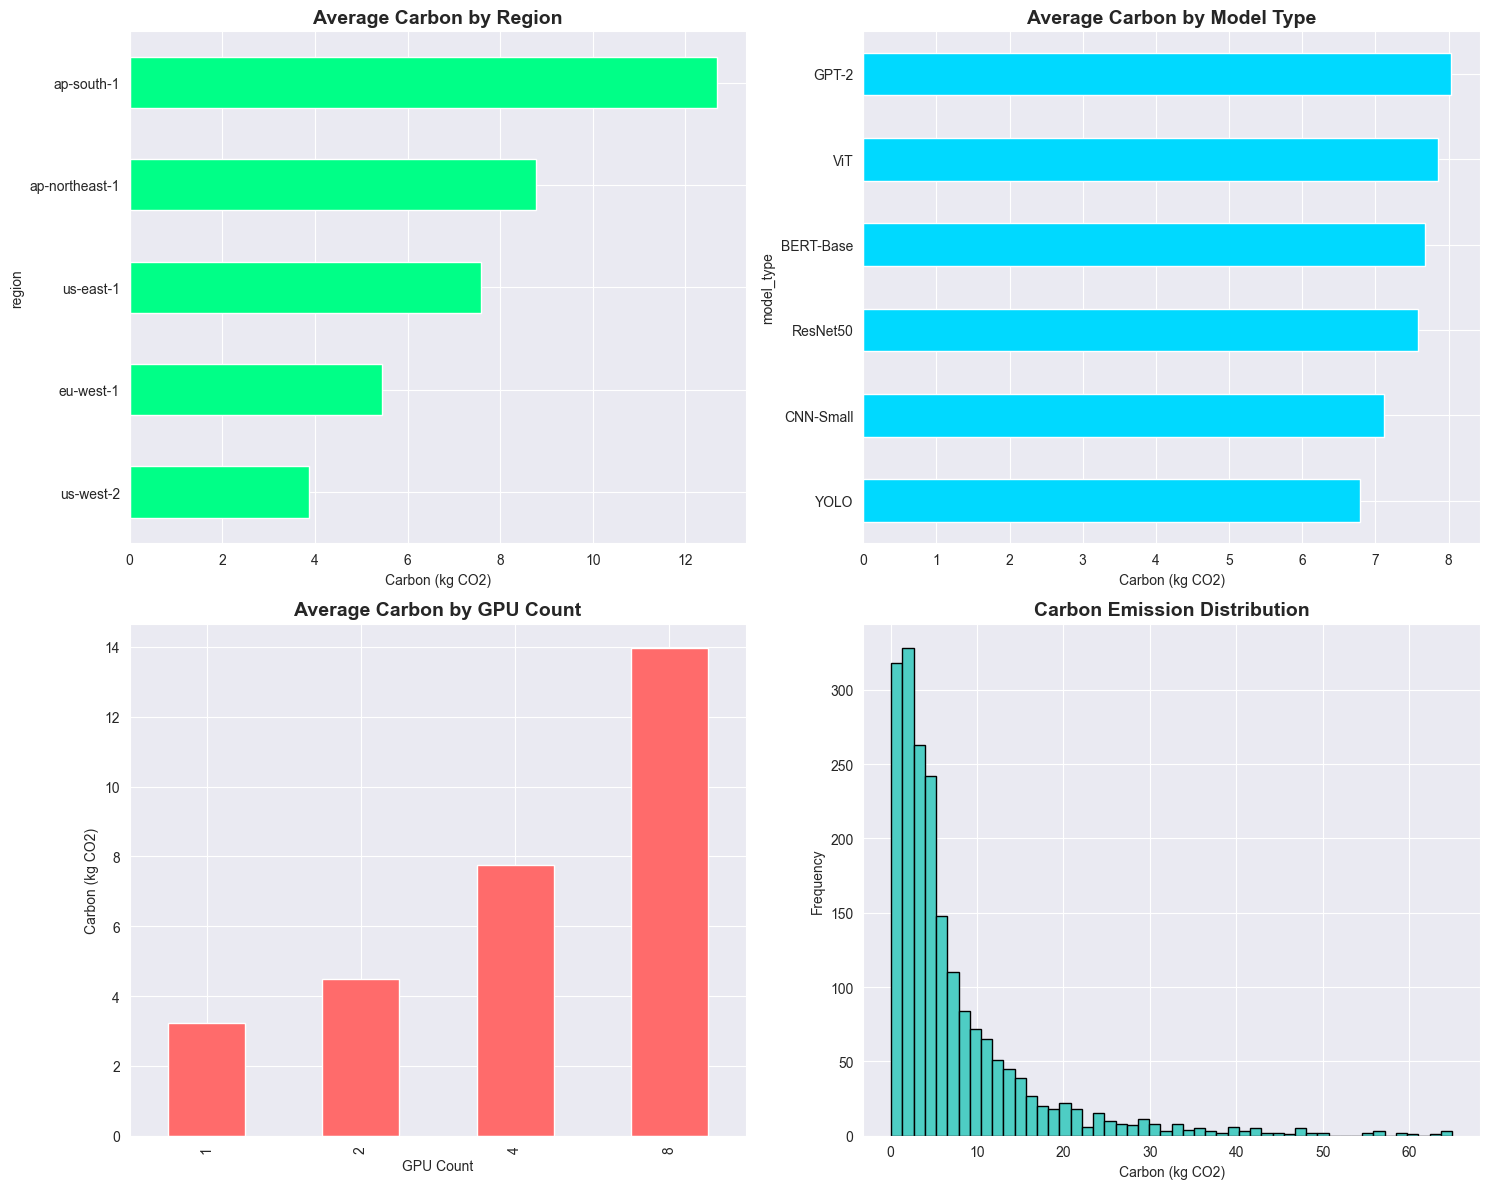

In [4]:
# Visualize data
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Carbon by region
df.groupby('region')['carbon_kg'].mean().sort_values().plot(
    kind='barh', ax=axes[0,0], color='#00FF87'
)
axes[0,0].set_title('Average Carbon by Region', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Carbon (kg CO2)')

# Carbon by model type
df.groupby('model_type')['carbon_kg'].mean().sort_values().plot(
    kind='barh', ax=axes[0,1], color='#00D9FF'
)
axes[0,1].set_title('Average Carbon by Model Type', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Carbon (kg CO2)')

# Carbon by GPU count
df.groupby('gpu_count')['carbon_kg'].mean().plot(
    kind='bar', ax=axes[1,0], color='#FF6B6B'
)
axes[1,0].set_title('Average Carbon by GPU Count', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('GPU Count')
axes[1,0].set_ylabel('Carbon (kg CO2)')

# Carbon distribution
axes[1,1].hist(df['carbon_kg'], bins=50, color='#4ECDC4', edgecolor='black')
axes[1,1].set_title('Carbon Emission Distribution', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Carbon (kg CO2)')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [5]:
# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()

le_model = LabelEncoder()
le_gpu = LabelEncoder()
le_region = LabelEncoder()

df_encoded['model_type_encoded'] = le_model.fit_transform(df['model_type'])
df_encoded['gpu_type_encoded'] = le_gpu.fit_transform(df['gpu_type'])
df_encoded['region_encoded'] = le_region.fit_transform(df['region'])

# Select features
features = [
    'model_type_encoded', 'batch_size', 'dataset_size_gb', 
    'gpu_count', 'gpu_type_encoded', 'duration_hours', 'region_encoded'
]

X = df_encoded[features]
y = df_encoded['carbon_kg']

print("✅ Features prepared:")
print(f"   Shape: {X.shape}")
print(f"   Features: {features}")

✅ Features prepared:
   Shape: (2000, 7)
   Features: ['model_type_encoded', 'batch_size', 'dataset_size_gb', 'gpu_count', 'gpu_type_encoded', 'duration_hours', 'region_encoded']


In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Random Forest
print("🌲 Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=200, 
    max_depth=15, 
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Train Gradient Boosting
print("🚀 Training Gradient Boosting...")
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    random_state=42
)
gb_model.fit(X_train, y_train)

# Evaluate
rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)

rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

gb_r2 = r2_score(y_test, gb_pred)
gb_mae = mean_absolute_error(y_test, gb_pred)

print(f"\n📊 Random Forest:")
print(f"   R² Score: {rf_r2:.4f}")
print(f"   MAE: {rf_mae:.4f} kg CO2")

print(f"\n📊 Gradient Boosting:")
print(f"   R² Score: {gb_r2:.4f}")
print(f"   MAE: {gb_mae:.4f} kg CO2")

# Choose best model
best_model = rf_model if rf_r2 > gb_r2 else gb_model
best_name = "Random Forest" if rf_r2 > gb_r2 else "Gradient Boosting"
print(f"\n🏆 Best Model: {best_name}")

🌲 Training Random Forest...
🚀 Training Gradient Boosting...

📊 Random Forest:
   R² Score: 0.9516
   MAE: 1.1378 kg CO2

📊 Gradient Boosting:
   R² Score: 0.9758
   MAE: 0.7112 kg CO2

🏆 Best Model: Gradient Boosting


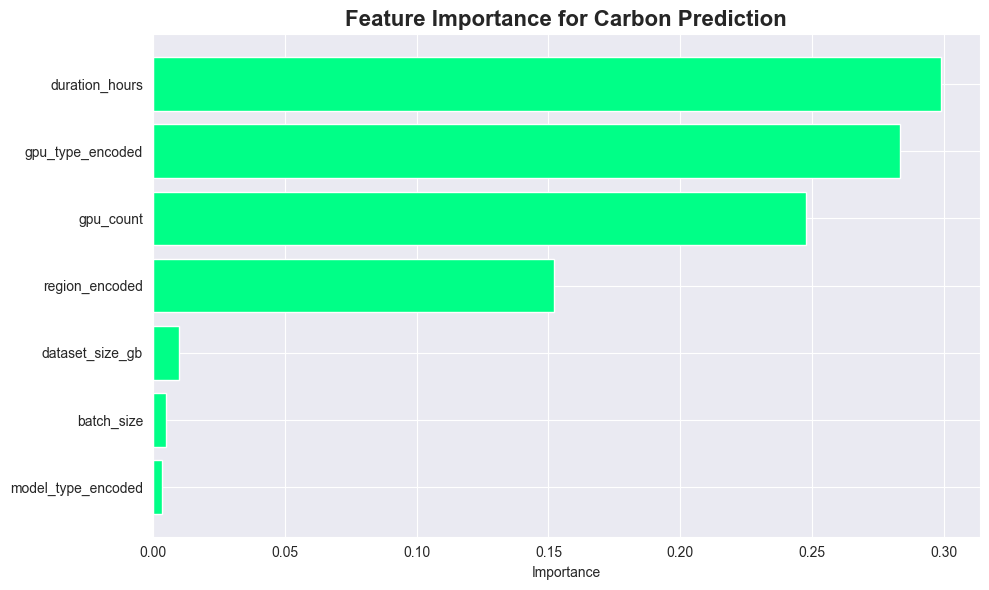

              feature  importance
5      duration_hours    0.298639
4    gpu_type_encoded    0.283262
3           gpu_count    0.247767
6      region_encoded    0.151967
2     dataset_size_gb    0.009939
1          batch_size    0.004855
0  model_type_encoded    0.003571


In [7]:
# Feature importance
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='#00FF87')
plt.xlabel('Importance')
plt.title('Feature Importance for Carbon Prediction', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(feature_importance_df)

In [8]:
# Save everything
joblib.dump(best_model, 'carbon_model.pkl')
joblib.dump(le_model, 'model_encoder.pkl')
joblib.dump(le_gpu, 'gpu_encoder.pkl')
joblib.dump(le_region, 'region_encoder.pkl')

# Save feature names
import json
with open('feature_names.json', 'w') as f:
    json.dump(features, f)

# Save region carbon map
with open('region_carbon.json', 'w') as f:
    json.dump(region_carbon_map, f)

print("✅ Model saved successfully!")
print("   📁 carbon_model.pkl")
print("   📁 model_encoder.pkl")
print("   📁 gpu_encoder.pkl")
print("   📁 region_encoder.pkl")
print("   📁 feature_names.json")
print("   📁 region_carbon.json")

✅ Model saved successfully!
   📁 carbon_model.pkl
   📁 model_encoder.pkl
   📁 gpu_encoder.pkl
   📁 region_encoder.pkl
   📁 feature_names.json
   📁 region_carbon.json


In [9]:
inference_code = '''
import joblib
import pandas as pd
import json
import numpy as np

# Load model and encoders
model = joblib.load('carbon_model.pkl')
model_encoder = joblib.load('model_encoder.pkl')
gpu_encoder = joblib.load('gpu_encoder.pkl')
region_encoder = joblib.load('region_encoder.pkl')

with open('region_carbon.json', 'r') as f:
    REGION_CARBON = json.load(f)

def predict_carbon(model_type, batch_size, dataset_size_gb, gpu_count, gpu_type, duration_hours, region):
    """
    Predict carbon emissions for an ML job
    """
    # Encode categorical variables
    model_encoded = model_encoder.transform([model_type])[0]
    gpu_encoded = gpu_encoder.transform([gpu_type])[0]
    region_encoded = region_encoder.transform([region])[0]
    
    # Create input dataframe
    input_data = pd.DataFrame([{
        'model_type_encoded': model_encoded,
        'batch_size': batch_size,
        'dataset_size_gb': dataset_size_gb,
        'gpu_count': gpu_count,
        'gpu_type_encoded': gpu_encoded,
        'duration_hours': duration_hours,
        'region_encoded': region_encoded
    }])
    
    # Predict
    prediction = model.predict(input_data)[0]
    
    return float(prediction)

def find_greenest_region(model_type, batch_size, dataset_size_gb, gpu_count, gpu_type, duration_hours):
    """
    Find the greenest region for this job
    """
    results = {}
    for region in REGION_CARBON.keys():
        carbon = predict_carbon(model_type, batch_size, dataset_size_gb, gpu_count, gpu_type, duration_hours, region)
        results[region] = carbon
    
    greenest = min(results, key=results.get)
    return greenest, results

if __name__ == "__main__":
    # Test
    result = predict_carbon('ResNet50', 32, 100, 2, 'V100', 4.0, 'us-east-1')
    print(f"Predicted carbon: {result:.2f} kg CO2")
'''

with open('predict.py', 'w') as f:
    f.write(inference_code)

print("✅ Inference script created: predict.py")

✅ Inference script created: predict.py


In [10]:
# Test the inference
from predict import predict_carbon, find_greenest_region

# Test case 1
test_carbon = predict_carbon(
    model_type='ResNet50',
    batch_size=32,
    dataset_size_gb=100,
    gpu_count=2,
    gpu_type='V100',
    duration_hours=4.0,
    region='us-east-1'
)

print(f"🧪 Test Prediction: {test_carbon:.2f} kg CO2")

# Find greenest region
greenest, all_regions = find_greenest_region(
    model_type='ResNet50',
    batch_size=32,
    dataset_size_gb=100,
    gpu_count=2,
    gpu_type='V100',
    duration_hours=4.0
)

print(f"\n🌍 Carbon by Region:")
for region, carbon in sorted(all_regions.items(), key=lambda x: x[1]):
    print(f"   {region}: {carbon:.2f} kg CO2")

print(f"\n✅ Greenest Region: {greenest} ({all_regions[greenest]:.2f} kg CO2)")
print(f"💰 Savings: {all_regions['us-east-1'] - all_regions[greenest]:.2f} kg CO2")

🧪 Test Prediction: 1.51 kg CO2

🌍 Carbon by Region:
   us-west-2: 0.91 kg CO2
   eu-west-1: 1.13 kg CO2
   us-east-1: 1.51 kg CO2
   ap-northeast-1: 1.93 kg CO2
   ap-south-1: 2.43 kg CO2

✅ Greenest Region: us-west-2 (0.91 kg CO2)
💰 Savings: 0.60 kg CO2
